## ANÁLISE DE COHORT ##


Já tem um tempo desde que vimos um projeto aplicado de Python, demonstrando como utilizar nossas skills para solucionar um problema de negócio. Já vimos isso para realizar a precificação de produtos e também na análise de Recência, Frequência e Valor. Hoje, vamos demonstrar como fazer uma análise de COHORT.

A análise de hoje é simples, mas muito útil, principalmente para quem trabalha com retenção de clientes. A ideia é mapear a entrada e saída da sua base, para entender a retenção ao longo do tempo. A tabela abaixo é o produto final de uma análise Cohort, feita em dias:

In [3]:
from IPython.display import Image

Image (url="https://lh6.googleusercontent.com/HmZLiwML0ie1GE4MZ1Q7FupxrRBzeSkUZ4dfH8aTz3SJXdKauAHiY3rYlUJioXZDW50ucAygSHg3Qr43rLeyKoscA7cfKCD2EWxc0KcKUh-LEZv5QMzWH0qXhotpFzCEIS5QpiVu0S134FTEu72J6Jo")

No exemplo acima, estamos falando do lançamento de um aplicativo, no qual 1.098 entraram no dia 25 de janeiro e, destes, 33.9% continuavam no dia seguinte; 23,5%, dois dias depois; 18,7% três dias depois e assim em diante. Fazemos isso diariamente, sempre registrando a entrada de clientes naquele dia e quantos permaneciam nos dias seguintes. Com isso, sabemos como anda a retenção de clientes. A depender do tipo de produto, a análise pode ser mais eficiente em meses.

### COMO CONSTRUIR UMA COHORT ###

Primeiro de tudo, você precisa ter uma tabela contendo algum tipo de recorrência de seus clientes. Por exemplo, quando fizemos nosso RFV, utilizamos um dataset de um e-commerce contendo as compras dos clientes. Aquele é um exemplo interessante para aplicar a análise que aprenderemos aqui. Para não repetir o dataset, vamos utilizar um dataset parecido, infelizmente vou apelar para um que já é um pouco manjado, mas pelo menos deixamos o do RFV para vocês validarem o entendimento obtido neste material. Você pode baixar o dataset deste material clicando

In [6]:
# Carregando Biblioteca
import pandas as pd

#Carregando Dataset
retail = pd.read_excel("Online Retail.xlsx")

#Exibe as primeiras linhas
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Temos no dataset, na ordem da primeira à última coluna: o código numérico que identifica a compra, o código numérico que identifica o item, a descrição do item em texto, a quantidade comprada, a data da compra, o preço unitário, a chave numérica de identificaçã

o do consumidor e o país da compra.

Se não conseguimos identificar o cliente, não vamos conseguir acompanhar seu comportamento ao longo do tempo. Por causa disso, vamos excluir linhas que não possuem a variável CustomerID preenchida.

In [7]:
retail.dropna( subset=['CustomerID'], inplace = True)

Não há muito o que a gente consiga fazer aqui, mas é interessante verificar como o dataset mudou de tamanho:

Perdemos uma quantidade razoável de linhas no dataset, cerca de 25%. Isso, no mundo real, é preocupante. Já vi projetos seguirem dessa forma, mas é o tipo de problemas de qualidade dos dados que deveria preocupar a equipe. Como aqui não temos muita ação sobre este problema, vamos apenas dar sequência.

Podemos realizar diversas análises dos dados, antes de começarmos efetivamente a gerar as cohorts. Geralmente, você verá as pessoas entendendo um pouco os dados, o que passa pela estatística descritiva das colunas:

In [8]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Veja que a quantidade média de itens por compras é em torno de 12, enquanto a mediana indica 5. Ou seja, temos uma distribuição bastante assimétrica.

Mais importante do que entender a visão geral, precisamos pegar as visões por consumidor. Afinal, se a demanda é de uma análise Cohort, é porque estamos entendendo nossos clientes. Sendo assim, como será que é a distribuição de compras feitas por nossos clientes? Quantas compras cada cliente fez?

Para responder à pergunta, basta contar quantos invoices cada cliente tem:

No contexto de vendas e análise de dados, "invoices" refere-se a faturas ou notas fiscais. Cada invoice é gerada quando uma compra é feita, representando um registro daquela transação.

No seu código e descrição, a ideia é verificar quantas faturas (ou transações) estão associadas a cada cliente para entender melhor o comportamento de compra. Contar os invoices por cliente ajuda a responder perguntas como:

Quantas compras um determinado cliente fez?
Qual o comportamento de compra recorrente dos clientes?
Assim, o número de invoices por cliente reflete quantas vezes esse cliente comprou na loja. É uma métrica útil para segmentar clientes e entender padrões de compras, especialmente em uma análise Cohort.

In [9]:
retail.groupby(["CustomerID"])["InvoiceNo"].nunique().sort_values()

CustomerID
15300.0      1
13833.0      1
16123.0      1
13829.0      1
13828.0      1
          ... 
13089.0    118
14606.0    128
17841.0    169
12748.0    224
14911.0    248
Name: InvoiceNo, Length: 4372, dtype: int64

Note que utilizamos nunique() e não size(). Isso foi feito porque queremos pegar quantos códigos de invoice, quantos números diferentes de invoice, cada cliente tem. Se utilizássemos size(), pegaríamos quantas linhas existem, e teríamos

um número bem maior porque o dataset possui repetições de invoices, cada compra pode ter mais de um item e isso faz com que tenhamos o mesmo número de invoice aparecendo diversas vezes.

In [10]:
invoice_per_costumer = retail.groupby(["CustomerID"])["InvoiceNo"].nunique()
invoice_per_costumer.describe()

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: InvoiceNo, dtype: float64

Podemos ver que há muitos clientes com poucas compras e alguns poucos com muitas compras, claramente assimétrica a distribuição de invoices pelos consumidores. Podemos ver o comportamento pelo histograma também:

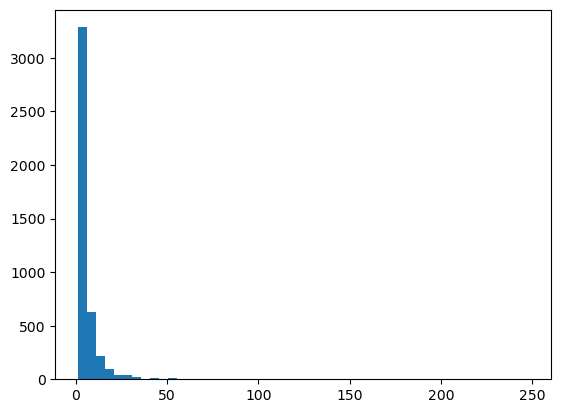

In [11]:
import matplotlib.pyplot as plt

_= plt.hist(invoice_per_costumer, bins=50)

É bem sutil, mas note que existem consumidores com 50, 100 e até 200 compras. Mas a maioria se encontra entre 0 e 5 compras.

Bom, agora podemos finalmente avançar para a cohort, já sabendo que podemos esperar pouca retenção. Lembra que a cohort é uma análise feita para verificar a retenção de clientes. No nosso caso, vamos identificar os clientes que seguem

realizando compras mensalmente. Sendo assim, o agrupamento será pela chave de identificação do cliente, a chave de identificação da compra e a data da compra: